# CIFAR3 Calibration Benchmark

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
from ternary import scatter
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.data import get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary, plot_nll_curve
from flows.normalizing_flows_torch import PlanarFlow, RadialFlow
from calibrators import TempScalingCalibrator, DummyCalibrator, TorchFlowCalibrator

/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: P

In [4]:
# Select GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [5]:
%matplotlib inline
np.random.seed(1)

## Load data

In [6]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

In [7]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

# val/test split
random_split = np.random.permutation(3000)

val_target = np.argmax(target[random_split[:1500], :], axis=1)
test_target = np.argmax(target[random_split[1500:], :], axis=1)

val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

### Visualize CIFAR3:

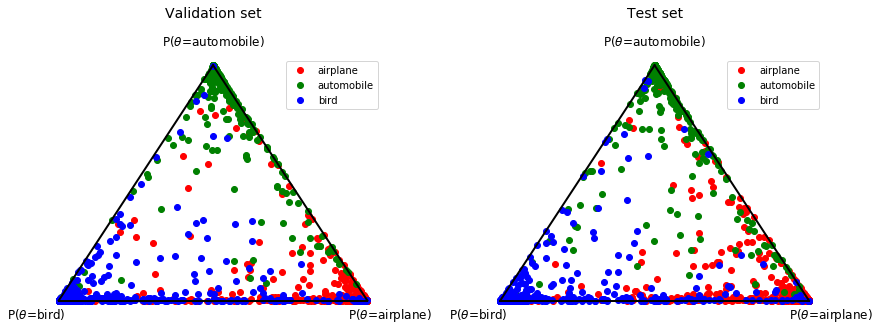

In [8]:
fig, ax_arr = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

ax_arr[0] = plot_prob_simplex(softmax(val_logits, 1), val_target, ax=ax_arr[0],
                              title='Validation set', labels=list(ix2label.values()))
ax_arr[1] = plot_prob_simplex(softmax(test_logits, 1), test_target, ax=ax_arr[1],
                              title='Test set', labels=list(ix2label.values()))
plt.show()

<IPython.core.display.Javascript object>


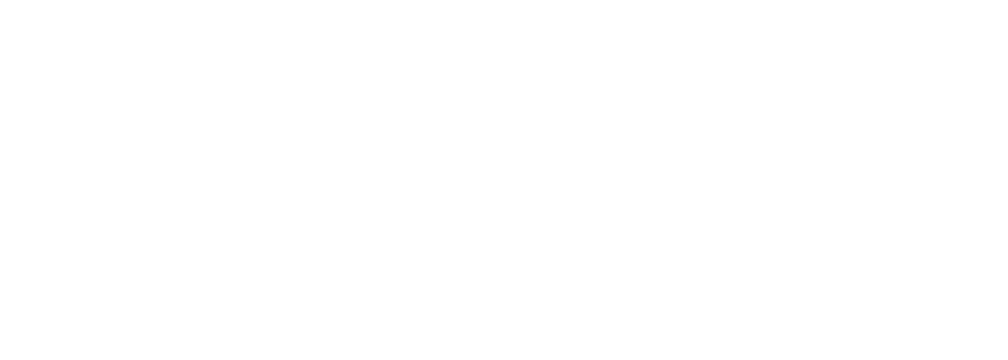

In [9]:
%matplotlib notebook  
%matplotlib notebook  
import matplotlib.pyplot as plt

colors = ['r', 'g', 'b']

fig = plt.figure(figsize=(14, 5))
fig.suptitle('Logits in 3D space', fontsize=12)
ax0 = fig.add_subplot(1,2,1, projection='3d')
ax1 = fig.add_subplot(1,2,2, projection='3d')

for i, c in enumerate(colors):
    
    ax0.scatter(val_logits[val_target==i, 0], val_logits[val_target==i, 1], val_logits[val_target==i, 2], c=c)
    ax1.scatter(test_logits[test_target==i, 0], test_logits[test_target==i, 1], test_logits[test_target==i, 2], c=c)
    
ax0.set_title('Validation set')
ax1.set_title('Test set')

ax0.set_xlabel(ix2label[0])
ax0.set_ylabel(ix2label[1])
ax0.set_zlabel(ix2label[2])

ax1.set_xlabel(ix2label[0])
ax1.set_ylabel(ix2label[1])
ax1.set_zlabel(ix2label[2])


plt.show();

### Helper methods:

In [10]:
def add_spoiling_samples(ax, pred_probs, target, probs):
    indv_nll = -np.sum(target*np.log(pred_probs+1e-7), axis=1)
    # spoiling_idx = np.argsort(indv_nll)[:-21:-1]
    spoiling_probs = probs[indv_nll>=np.log2(3), :]
    spoiling_target = np.argmax(target[indv_nll>=np.log2(3), :], axis=1)

    ax.scatter(spoiling_probs[spoiling_target==0, :]*ax._scale, s=50, color='red', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==1, :]*ax._scale, s=50, color='green', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==2, :]*ax._scale, s=50, color='blue', edgecolors='k', lw=1, zorder=2)
    
    return ax

In [11]:
def train_and_eval_cal(Calibrator):
    results = {}
    t = time.time()
    cal = Calibrator(val_logits, val_target)
    print('Calibrator fitted in {:.3f}s'.format(time.time()-t))
    results['nll_val'] = neg_log_likelihood(cal(val_logits), val_target)
    results['ece_val'] = expected_calibration_error(cal(val_logits), val_target)
    results['nll_test'] = neg_log_likelihood(cal(test_logits), test_target)
    results['ece_test'] = expected_calibration_error(cal(test_logits), test_target)
    results['cal'] = cal
    
    return results

## Train Calibrators

In [12]:
calibrators = {
    'Uncalibrated': DummyCalibrator,
    'Temp-Scaling': TempScalingCalibrator,
}

layers = [2, 6, 10, 20, 30, 50, 100]

planar_args = [
    {
        'layers': l,
        'epochs': 1000,
        'batch_size': val_logits.shape[0],
    } for l in layers
]

radial_args = [
    {
        'layers': l,
        'epochs': 1000,
        'batch_size': val_logits.shape[0],
    } for l in layers
]

for planar in planar_args:
    name = 'Planar_l{}'.format(planar['layers'])
    calibrators[name] = lambda logits, target: TorchFlowCalibrator(PlanarFlow, logits, target, **planar)

for radial in radial_args:
    name = 'Radial_l{}'.format(radial['layers'])
    calibrators[name] = lambda logits, target: TorchFlowCalibrator(RadialFlow, logits, target, **radial)

In [13]:
# Train all calibrators
results = {}
for name, Calibrator in calibrators.items():
    print('Training {:s}...'.format(name))
    results[name] = train_and_eval_cal(Calibrator)

Training Uncalibrated...
Calibrator fitted in 0.000s
Training Temp-Scaling...
Calibrator fitted in 0.010s
Training Planar_l2...
Calibrator fitted in 153.072s
Training Planar_l6...
Calibrator fitted in 146.609s
Training Planar_l10...
Calibrator fitted in 146.715s
Training Planar_l20...
Calibrator fitted in 146.571s
Training Planar_l30...
Calibrator fitted in 146.508s
Training Planar_l50...
Calibrator fitted in 146.745s
Training Planar_l100...
Calibrator fitted in 146.779s
Training Radial_l2...
Calibrator fitted in 125.852s
Training Radial_l6...
Calibrator fitted in 125.397s
Training Radial_l10...
Calibrator fitted in 125.481s
Training Radial_l20...
Calibrator fitted in 125.085s
Training Radial_l30...
Calibrator fitted in 125.179s
Training Radial_l50...
Calibrator fitted in 125.256s
Training Radial_l100...
Calibrator fitted in 124.986s


In [14]:
results['Radial_l20']['cal'].history['loss']

[2.720736265182495,
 2.711219549179077,
 2.7017157077789307,
 2.6922249794006348,
 2.6827480792999268,
 2.6732842922210693,
 2.6638340950012207,
 2.65439772605896,
 2.6449742317199707,
 2.635564088821411,
 2.626168727874756,
 2.616786479949951,
 2.607417583465576,
 2.598062753677368,
 2.588721513748169,
 2.5793941020965576,
 2.5700809955596924,
 2.560781478881836,
 2.5514955520629883,
 2.5422229766845703,
 2.5329644680023193,
 2.523719072341919,
 2.5144872665405273,
 2.5052690505981445,
 2.4960641860961914,
 2.4868721961975098,
 2.4776930809020996,
 2.46852707862854,
 2.459373950958252,
 2.450233221054077,
 2.441105842590332,
 2.431990623474121,
 2.4228878021240234,
 2.4137978553771973,
 2.404719352722168,
 2.395653247833252,
 2.386599540710449,
 2.3775575160980225,
 2.368527412414551,
 2.359508752822876,
 2.3505024909973145,
 2.341508150100708,
 2.332524299621582,
 2.3235526084899902,
 2.3145923614501953,
 2.305643320083618,
 2.296706438064575,
 2.2877798080444336,
 2.2788639068603516

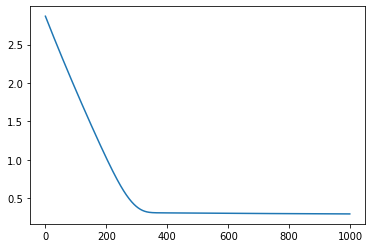

In [15]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(results['Radial_l30']['cal'].history['loss'])
plt.show()

## Comparing flows:

### Overfitting:

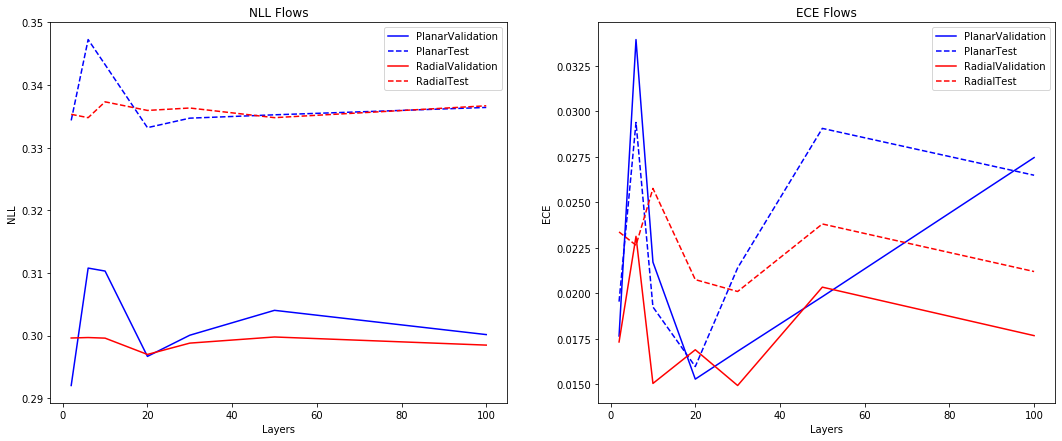

In [16]:
colors = ['b', 'r', 'g', 'y']
flows = ['Planar_l{}', 'Radial_l{}']
%matplotlib inline

fig, ax_arr = plt.subplots(1, 2, figsize=(18, 7))

for color, flow in zip(colors, flows):
    val_nll = []
    test_nll = []
    val_ece = []
    test_ece = []
    for l in layers:
        val_nll.append(results[flow.format(l)]['nll_val'])
        test_nll.append(results[flow.format(l)]['nll_test'])
        val_ece.append(results[flow.format(l)]['ece_val'])
        test_ece.append(results[flow.format(l)]['ece_test'])
    ax_arr[0].plot(layers, val_nll, color, label=flow.split('_')[0] + 'Validation')
    ax_arr[0].plot(layers, test_nll, color + '--', label=flow.split('_')[0] + 'Test')

    ax_arr[1].plot(layers, val_ece, color, label=flow.split('_')[0] + 'Validation')
    ax_arr[1].plot(layers, test_ece, color + '--', label=flow.split('_')[0] + 'Test')


ax_arr[0].legend()
ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_xlabel('Layers')
ax_arr[0].set_title('NLL Flows')

ax_arr[1].legend()
ax_arr[1].set_ylabel('ECE')
ax_arr[1].set_xlabel('Layers')
ax_arr[1].set_title('ECE Flows')

plt.show()